In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import tensorflow as tf

import os
import pickle
import re
from tensorflow.python.ops import math_ops

In [5]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile
import hashlib

def _unzip(save_path, _, database_name, data_path):
    """
    Unzip wrapper with the same interface as _ungzip
    :param save_path: The path of the gzip files
    :param database_name: Name of database
    :param data_path: Path to extract to
    :param _: HACK - Used to have to same interface as _ungzip
    """
    print('Extracting {}...'.format(database_name))
    with zipfile.ZipFile(save_path) as zf:
        zf.extractall(data_path)

def download_extract(database_name, data_path):
    """
    Download and extract database
    :param database_name: Database name
    """
    DATASET_ML1M = 'ml-1m'

    if database_name == DATASET_ML1M:
        url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
        hash_code = 'c4d9eecfca2ab87c1945afe126590906'
        extract_path = os.path.join(data_path, 'ml-1m')
        save_path = os.path.join(data_path, 'ml-1m.zip')
        extract_fn = _unzip

    if os.path.exists(extract_path):
        print('Found {} Data'.format(database_name))
        return

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(save_path):
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Downloading {}'.format(database_name)) as pbar:
            urlretrieve(
                url,
                save_path,
                pbar.hook)

    assert hashlib.md5(open(save_path, 'rb').read()).hexdigest() == hash_code, \
        '{} file is corrupted.  Remove the file and try again.'.format(save_path)

    os.makedirs(extract_path)
    try:
        extract_fn(save_path, extract_path, database_name, data_path)
    except Exception as err:
        shutil.rmtree(extract_path)  # Remove extraction folder if there is an error
        raise err

    print('Done.')
    # Remove compressed data
#     os.remove(save_path)

class DLProgress(tqdm):
    """
    Handle Progress Bar while Downloading
    """
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        """
        A hook function that will be called once on establishment of the network connection and
        once after each block read thereafter.
        :param block_num: A count of blocks transferred so far
        :param block_size: Block size in bytes
        :param total_size: The total size of the file. This may be -1 on older FTP servers which do not return
                            a file size in response to a retrieval request.
        """
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

In [6]:
data_dir = './'
download_extract('ml-1m', data_dir)

Extracting ml-1m...
Done.


### User Features

In [7]:
users_title = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
users.head()

,UserID,Gender,Age,OccupationID,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [9]:
len(users)

6040

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"



### Movie Features

In [242]:
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [266]:
len(movies)

3883

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western

### Ratings

In [209]:
ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
ratings.head()

,UserID,MovieID,Rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## Data Cleaning and Preproccessing

### 1.User Features

1. Gender: M->1 F->0
2. Age buckets to :0-6

In [13]:
set(users['Age'])

{1, 18, 25, 35, 45, 50, 56}

In [19]:
age_map = {val:ii for ii,val in enumerate(set(users['Age']))}

In [20]:
age_map

{1: 0, 35: 1, 45: 2, 50: 3, 18: 4, 56: 5, 25: 6}

In [22]:
pattern = re.compile(r'^(.*)\((\d+)\)$')
title_map = {val:pattern.match(val).group(1) for ii,val in enumerate(set(movies['Title']))}
title_map

{'Kolya (1996)': 'Kolya ',
 'Lost & Found (1999)': 'Lost & Found ',
 "I Can't Sleep (J'ai pas sommeil) (1994)": "I Can't Sleep (J'ai pas sommeil) ",
 'Soft Fruit (1999)': 'Soft Fruit ',
 'Close Shave, A (1995)': 'Close Shave, A ',
 'Liberty Heights (1999)': 'Liberty Heights ',
 'Born to Win (1971)': 'Born to Win ',
 'Paris Was a Woman (1995)': 'Paris Was a Woman ',
 'Open Your Eyes (Abre los ojos) (1997)': 'Open Your Eyes (Abre los ojos) ',
 'Risky Business (1983)': 'Risky Business ',
 'Mina Tannenbaum (1994)': 'Mina Tannenbaum ',
 'Kidnapped (1960)': 'Kidnapped ',
 'Pale Rider (1985)': 'Pale Rider ',
 'Monkey Shines (1988)': 'Monkey Shines ',
 'Anywhere But Here (1999)': 'Anywhere But Here ',
 'Jaws (1975)': 'Jaws ',
 'Slipper and the Rose, The (1976)': 'Slipper and the Rose, The ',
 "Dead Men Don't Wear Plaid (1982)": "Dead Men Don't Wear Plaid ",
 'Basketball Diaries, The (1995)': 'Basketball Diaries, The ',
 'Bogus (1996)': 'Bogus ',
 'Losing Chase (1996)': 'Losing Chase ',
 'That 

### 2. Movie Features

1. Titles:  
(1) Drop the release year  
(2) Map words of list into list of integers  
(3) To save computation, we gonna  make each title list of the same length, we set it to be 15 bc that is max length of title column.   
If the movie title is less than 15 words, then it will be padded with space number:2940.   

2.Genres:  
(1) Same thing we did with Titles, since one movie could have multiple genres, we will make the length to be 18 which is the max number of movie genres. If the length is less than 18, spaces will be padded with number:14.  

In [23]:
genres_set = set()
for val in movies['Genres'].str.split('|'):
    genres_set.update(val)

genres_set.add('<PAD>')
genres2int = {val:ii for ii, val in enumerate(genres_set)}


genres_map = {val:[genres2int[row] for row in val.split('|')] for ii,val in enumerate(set(movies['Genres']))}

for key in genres_map:
    for cnt in range(max(genres2int.values()) - len(genres_map[key])):
        genres_map[key].insert(len(genres_map[key]) + cnt,genres2int['<PAD>'])
    
movies['Genres'] = movies['Genres'].map(genres_map)

In [28]:
genres2int

{'Sci-Fi': 0,
 'Action': 1,
 'Musical': 2,
 'Crime': 3,
 'Film-Noir': 4,
 'Romance': 5,
 'Mystery': 6,
 'War': 7,
 'Comedy': 8,
 "Children's": 9,
 'Thriller': 10,
 'Horror': 11,
 'Fantasy': 12,
 'Drama': 13,
 '<PAD>': 14,
 'Animation': 15,
 'Documentary': 16,
 'Western': 17,
 'Adventure': 18}

In [30]:
title_set = set()
for val in movies['Title'].str.split():
    title_set.update(val)
    
title_set.add('<PAD>')
title2int = {val:ii for ii, val in enumerate(title_set)}
    
title_count = 15
title_map = {val:[title2int[row] for row in val.split()] for ii,val in enumerate(set(movies['Title']))}
    
for key in title_map:
    for cnt in range(title_count - len(title_map[key])):
        title_map[key].insert(len(title_map[key]) + cnt,title2int['<PAD>'])
    
movies['Title'] = movies['Title'].map(title_map)

In [32]:
title2int

{'Face/Off': 0,
 'September': 1,
 'Max': 2,
 'Marnie': 3,
 'EDtv': 4,
 'Wilde': 5,
 'Following': 6,
 'GoldenEye': 7,
 "L'": 8,
 'Reservoir': 9,
 'Trial,': 10,
 'Josey': 11,
 'Entertaining': 12,
 'Broomsticks': 13,
 'Crows': 14,
 'Teenage': 15,
 'Wag': 16,
 'Batman:': 17,
 '(Uomo': 18,
 'Sing': 19,
 '(Pane': 20,
 '(Leggenda': 21,
 'Daens': 22,
 'Guido': 23,
 '(1941)': 24,
 'Outer': 25,
 '24': 26,
 'Lone': 27,
 'Doom': 28,
 'Pulp': 29,
 'Cries,': 30,
 '(Como': 31,
 'Rush': 32,
 'Saragossie)': 33,
 'Above': 34,
 'Holy': 35,
 'Kid,': 36,
 'Talking': 37,
 'On': 38,
 '(Feng': 39,
 'Killers,': 40,
 'Bandit': 41,
 'Funny': 42,
 'Saphead,': 43,
 'Amityville:': 44,
 'Expectations': 45,
 'Cable': 46,
 'Saltmen': 47,
 'Fabulous': 48,
 'Down:': 49,
 'Godfather,': 50,
 'Puppet': 51,
 'Basement!': 52,
 'Broke,': 53,
 'James': 54,
 'Twilight': 55,
 'Ned': 56,
 'Cherry': 57,
 'Arrow': 58,
 'County,': 59,
 'Stars': 60,
 'Cause': 61,
 'Nights': 62,
 'Murderer': 63,
 'Andy': 64,
 'Core': 65,
 'Reality': 6

### 3. Use a function to merge all transformations

In [249]:
def load_data():
    """
    Load Dataset from File
    """
  
    users_title = ['UserID', 'Gender', 'Age', 'JobID', 'Zip-code']
    users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
    users = users.filter(regex='UserID|Gender|Age|JobID')
    users_orig = users.values

    gender_map = {'F':0, 'M':1}
    users['Gender'] = users['Gender'].map(gender_map)

    age_map = {val:ii for ii,val in enumerate(set(users['Age']))}
    users['Age'] = users['Age'].map(age_map)

    movies_title = ['MovieID', 'Title', 'Genres']
    movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
    movies_orig = movies.values

    pattern = re.compile(r'^(.*)\((\d+)\)$')

    title_map = {val:pattern.match(val).group(1) for ii,val in enumerate(set(movies['Title']))}
    movies['Title'] = movies['Title'].map(title_map)


    genres_set = set()
    for val in movies['Genres'].str.split('|'):
        genres_set.update(val)

    genres_set.add('<PAD>')
    genres2int = {val:ii for ii, val in enumerate(genres_set)}


    genres_map = {val:[genres2int[row] for row in val.split('|')] for ii,val in enumerate(set(movies['Genres']))}

    for key in genres_map:
        for cnt in range(max(genres2int.values()) - len(genres_map[key])):
            genres_map[key].insert(len(genres_map[key]) + cnt,genres2int['<PAD>'])
    
    movies['Genres'] = movies['Genres'].map(genres_map)


    title_set = set()
    for val in movies['Title'].str.split():
        title_set.update(val)
    
    title_set.add('<PAD>')
    title2int = {val:ii for ii, val in enumerate(title_set)}


    title_count = 15
    title_map = {val:[title2int[row] for row in val.split()] for ii,val in enumerate(set(movies['Title']))}
    
    for key in title_map:
        for cnt in range(title_count - len(title_map[key])):
            title_map[key].insert(len(title_map[key]) + cnt,title2int['<PAD>'])
    
    movies['Title'] = movies['Title'].map(title_map)

    ratings_title = ['UserID','MovieID', 'ratings', 'timestamps']
    ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
    ratings = ratings.filter(regex='UserID|MovieID|ratings')


    data = pd.merge(pd.merge(ratings, users), movies)
    
    target_fields = ['ratings']
    features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]
    
    features = features_pd.values
    targets_values = targets_pd.values
    
    return title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig

In [250]:
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = load_data()

pickle.dump((title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig), open('preprocess.p', 'wb'))

### 4. Results of data cleaning and preprocessing

In [252]:
users

,UserID,Gender,Age,JobID
0,1,0,0,10
1,2,1,5,16
2,3,1,6,15
3,4,1,2,7
4,5,1,6,20
...,...,...,...,...
6035,6036,0,6,15
6036,6037,0,2,1
6037,6038,0,5,1
6038,6039,0,2,0


In [253]:
movies

,MovieID,Title,Genres
0,1,"[1112, 2035, 2940, 2940, 2940, 2940, 2940, 294...","[15, 9, 8, 14, 14, 14, 14, 14, 14, 14, 14, 14,..."
1,2,"[4596, 2940, 2940, 2940, 2940, 2940, 2940, 294...","[18, 9, 12, 14, 14, 14, 14, 14, 14, 14, 14, 14..."
2,3,"[164, 1498, 570, 2940, 2940, 2940, 2940, 2940,...","[8, 5, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,..."
3,4,"[233, 5012, 3028, 2940, 2940, 2940, 2940, 2940...","[8, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14..."
4,5,"[3672, 4648, 3133, 3032, 1898, 2700, 2940, 294...","[8, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14..."
...,...,...,...
3878,3948,"[1032, 3133, 2421, 2940, 2940, 2940, 2940, 294...","[8, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14..."
3879,3949,"[5152, 1625, 1560, 990, 2940, 2940, 2940, 2940...","[13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 1..."
3880,3950,"[4262, 2940, 2940, 2940, 2940, 2940, 2940, 294...","[13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 1..."
3881,3951,"[4462, 4711, 3956, 2940, 2940, 2940, 2940, 294...","[13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 1..."


In [40]:
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = pickle.load(open('preprocess.p', mode='rb'))

## Model parameters setting

In [41]:
import tensorflow as tf
import os
import pickle

def save_params(params):
    """
    Save parameters to file
    """
    pickle.dump(params, open('params.p', 'wb'))


def load_params():
    """
    Load parameters from file
    """
    return pickle.load(open('params.p', mode='rb'))


###  1. Setting parameters for layers

In [42]:
#Embedding layer number
embed_dim = 32

#User features
uid_max = max(features.take(0,1)) + 1 # 6040
gender_max = max(features.take(2,1)) + 1 # 1 + 1 = 2
age_max = max(features.take(3,1)) + 1 # 6 + 1 = 7
job_max = max(features.take(4,1)) + 1# 20 + 1 = 21

#Movie features
movie_id_max = max(features.take(1,1)) + 1 # 3952
movie_categories_max = max(genres2int.values()) + 1 # 18 + 1 = 19
movie_title_max = len(title_set) # 5216

#sentence length
sentences_size = title_count # = 15

#window size for Text CNN
window_sizes = {2, 3, 4, 5}
filter_num = 8

movieid2idx = {val[0]:i for i, val in enumerate(movies.values)}

### 2.Hyperparameters

In [62]:
num_epochs = 5
batch_size = 256

dropout_keep = 0.5
learning_rate = 0.0001
show_every_n_batches = 20

save_dir = './save'

### 3. Setting inputs

In [65]:
def get_inputs():
    uid = tf.keras.layers.Input(shape=(1,), dtype='int32', name='uid')  
    user_gender = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_gender')  
    user_age = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_age') 
    user_job = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_job')

    movie_id = tf.keras.layers.Input(shape=(1,), dtype='int32', name='movie_id') 
    movie_categories = tf.keras.layers.Input(shape=(18,), dtype='int32', name='movie_categories') 
    movie_titles = tf.keras.layers.Input(shape=(15,), dtype='int32', name='movie_titles') 
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles

## Model Framework

### 1. User Embeddings

In [66]:
def get_user_embedding(uid, user_gender, user_age, user_job):
    uid_embed_layer = tf.keras.layers.Embedding(uid_max, embed_dim, input_length=1, name='uid_embed_layer')(uid)
    gender_embed_layer = tf.keras.layers.Embedding(gender_max, embed_dim // 2, input_length=1, name='gender_embed_layer')(user_gender)
    age_embed_layer = tf.keras.layers.Embedding(age_max, embed_dim // 2, input_length=1, name='age_embed_layer')(user_age)
    job_embed_layer = tf.keras.layers.Embedding(job_max, embed_dim // 2, input_length=1, name='job_embed_layer')(user_job)
    return uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer

### 2. Connect embedding layers into dense layers

In [202]:
def get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer):
    
    uid_fc_layer = tf.keras.layers.Dense(embed_dim, name="uid_fc_layer", activation='relu')(uid_embed_layer)
    gender_fc_layer = tf.keras.layers.Dense(embed_dim, name="gender_fc_layer", activation='relu')(gender_embed_layer)
    age_fc_layer = tf.keras.layers.Dense(embed_dim, name="age_fc_layer", activation='relu')(age_embed_layer)
    job_fc_layer = tf.keras.layers.Dense(embed_dim, name="job_fc_layer", activation='relu')(job_embed_layer)

    
    user_combine_layer = tf.keras.layers.concatenate([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer], 2) 
    user_combine_layer = tf.keras.layers.Dense(200, activation='tanh')(user_combine_layer)  

    user_combine_layer_flat = tf.keras.layers.Reshape([200], name="user_combine_layer_flat")(user_combine_layer)
    return user_combine_layer, user_combine_layer_flat

### 3. Movie Embeddings

In [74]:
def get_movie_id_embed_layer(movie_id):
    movie_id_embed_layer = tf.keras.layers.Embedding(movie_id_max, embed_dim, input_length=1, name='movie_id_embed_layer')(movie_id)
    return movie_id_embed_layer

### 4. Connect movie embedding layers into dense layers

In [75]:
def get_movie_categories_layers(movie_categories):
    movie_categories_embed_layer = tf.keras.layers.Embedding(movie_categories_max, embed_dim, input_length=18, name='movie_categories_embed_layer')(movie_categories)
    movie_categories_embed_layer = tf.keras.layers.Lambda(lambda layer: tf.reduce_sum(layer, axis=1, keepdims=True))(movie_categories_embed_layer)
#     movie_categories_embed_layer = tf.keras.layers.Reshape([1, 18 * embed_dim])(movie_categories_embed_layer)

    return movie_categories_embed_layer

### 5. Setting Text Convolutional neural network layers for movie title features

In [107]:
def get_movie_cnn_layer(movie_titles):
    movie_title_embed_layer = tf.keras.layers.Embedding(movie_title_max, embed_dim, input_length=15, name='movie_title_embed_layer')(movie_titles)
    sp=movie_title_embed_layer.shape
    movie_title_embed_layer_expand = tf.keras.layers.Reshape([sp[1], sp[2], 1])(movie_title_embed_layer)
    
    pool_layer_lst = []
    for window_size in window_sizes:
        conv_layer = tf.keras.layers.Conv2D(filter_num, (window_size, embed_dim), 1, activation='relu')(movie_title_embed_layer_expand)
        maxpool_layer = tf.keras.layers.MaxPooling2D(pool_size=(sentences_size - window_size + 1 ,1), strides=1)(conv_layer)
        pool_layer_lst.append(maxpool_layer)
    #Dropout层
    pool_layer = tf.keras.layers.concatenate(pool_layer_lst, 3, name ="pool_layer")  
    max_num = len(window_sizes) * filter_num
    pool_layer_flat = tf.keras.layers.Reshape([1, max_num], name = "pool_layer_flat")(pool_layer)

    dropout_layer = tf.keras.layers.Dropout(dropout_keep, name = "dropout_layer")(pool_layer_flat) #0.5 remaining rate
    return pool_layer_flat, dropout_layer

### 6. Connect all movie dense layers and movie title CNN layers all together

In [77]:
def get_movie_feature_layer(movie_id_embed_layer, movie_categories_embed_layer, dropout_layer):
   
    movie_id_fc_layer = tf.keras.layers.Dense(embed_dim, name="movie_id_fc_layer", activation='relu')(movie_id_embed_layer)
    movie_categories_fc_layer = tf.keras.layers.Dense(embed_dim, name="movie_categories_fc_layer", activation='relu')(movie_categories_embed_layer)

    movie_combine_layer = tf.keras.layers.concatenate([movie_id_fc_layer, movie_categories_fc_layer, dropout_layer], 2)  
    movie_combine_layer = tf.keras.layers.Dense(200, activation='tanh')(movie_combine_layer)

    movie_combine_layer_flat = tf.keras.layers.Reshape([200], name="movie_combine_layer_flat")(movie_combine_layer)
    return movie_combine_layer, movie_combine_layer_flat

## Build Calculation Graph

In [216]:
import tensorflow as tf
import datetime
from tensorflow import keras
from tensorflow.python.ops import summary_ops_v2
import time

MODEL_DIR = "./models"


class mv_network(object):
    def __init__(self, batch_size=256):
        self.batch_size = batch_size
        self.best_loss = 9999
        self.losses = {'train': [], 'test': []}

        uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles = get_inputs()

        uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer = get_user_embedding(uid, user_gender,

        user_combine_layer, user_combine_layer_flat = get_user_feature_layer(uid_embed_layer, gender_embed_layer,
                                                                             age_embed_layer, job_embed_layer)
    
        movie_id_embed_layer = get_movie_id_embed_layer(movie_id)

        movie_categories_embed_layer = get_movie_categories_layers(movie_categories)
    
        pool_layer_flat, dropout_layer = get_movie_cnn_layer(movie_titles)

        movie_combine_layer, movie_combine_layer_flat = get_movie_feature_layer(movie_id_embed_layer,
                                                                                movie_categories_embed_layer,
                                                                                dropout_layer)

        inference = tf.keras.layers.Lambda(lambda layer: 
            tf.reduce_sum(layer[0] * layer[1], axis=1), name="inference")((user_combine_layer_flat, movie_combine_layer_flat))
        inference = tf.keras.layers.Lambda(lambda layer: tf.expand_dims(layer, axis=1))(inference)
     
        self.model = tf.keras.Model(
            inputs=[uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles],
            outputs=[inference])

        self.model.summary()

        self.optimizer = tf.keras.optimizers.Adam(learning_rate)

        self.ComputeLoss = tf.keras.losses.MeanSquaredError()
        self.ComputeMetrics = tf.keras.metrics.MeanAbsoluteError()

        if tf.io.gfile.exists(MODEL_DIR):
            pass
        else:
            tf.io.gfile.makedirs(MODEL_DIR)

        train_dir = os.path.join(MODEL_DIR, 'summaries', 'train')
        test_dir = os.path.join(MODEL_DIR, 'summaries', 'eval')

        checkpoint_dir = os.path.join(MODEL_DIR, 'checkpoints')
        self.checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
        self.checkpoint = tf.train.Checkpoint(model=self.model, optimizer=self.optimizer)

        self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

    def compute_loss(self, labels, logits):
        return tf.reduce_mean(tf.keras.losses.mse(labels, logits))

    def compute_metrics(self, labels, logits):
        return tf.keras.metrics.mae(labels, logits)  #

    @tf.function
    def train_step(self, x, y):

        with tf.GradientTape() as tape:
            logits = self.model([x[0],
                                 x[1],
                                 x[2],
                                 x[3],
                                 x[4],
                                 x[5],
                                 x[6]], training=True)
            loss = self.ComputeLoss(y, logits)
            self.ComputeMetrics(y, logits)

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss, logits

    def training(self, features, targets_values, epochs=5, log_freq=50):

        for epoch_i in range(epochs):
            
            train_X, test_X, train_y, test_y = train_test_split(features,
                                                                targets_values,
                                                                test_size=0.2,
                                                                random_state=0)

            train_batches = get_batches(train_X, train_y, self.batch_size)
            batch_num = (len(train_X) // self.batch_size)

            train_start = time.time()
            if True:
                start = time.time()
                avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)

                for batch_i in range(batch_num):
                    x, y = next(train_batches)
                    categories = np.zeros([self.batch_size, 18])
                    for i in range(self.batch_size):
                        categories[i] = x.take(6, 1)[i]

                    titles = np.zeros([self.batch_size, sentences_size])
                    for i in range(self.batch_size):
                        titles[i] = x.take(5, 1)[i]

                    loss, logits = self.train_step([np.reshape(x.take(0, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(2, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(3, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(4, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(1, 1), [self.batch_size, 1]).astype(np.float32),
                                                    categories.astype(np.float32),
                                                    titles.astype(np.float32)],
                                                   np.reshape(y, [self.batch_size, 1]).astype(np.float32))
                    avg_loss(loss)
                    self.losses['train'].append(loss)

                    if tf.equal(self.optimizer.iterations % log_freq, 0):

                        rate = log_freq / (time.time() - start)
                        print('Step #{}\tEpoch {:>3} Batch {:>4}/{}   Loss: {:0.6f} mae: {:0.6f} ({} steps/sec)'.format(
                            self.optimizer.iterations.numpy(),
                            epoch_i,
                            batch_i,
                            batch_num,
                            loss, (self.ComputeMetrics.result()), rate))

                        avg_loss.reset_states()
                        self.ComputeMetrics.reset_states()

                        start = time.time()

            train_end = time.time()
            print(
                '\nTrain time for epoch #{} ({} total steps): {}'.format(epoch_i + 1, self.optimizer.iterations.numpy(),
                                                                         train_end - train_start))
            self.testing((test_X, test_y), self.optimizer.iterations)

        self.export_path = os.path.join(MODEL_DIR, 'export')
        tf.saved_model.save(self.model, self.export_path)

    def testing(self, test_dataset, step_num):
        test_X, test_y = test_dataset
        test_batches = get_batches(test_X, test_y, self.batch_size)

        """Perform an evaluation of `model` on the examples from `dataset`."""
        avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)

        batch_num = (len(test_X) // self.batch_size)
        for batch_i in range(batch_num):
            x, y = next(test_batches)
            categories = np.zeros([self.batch_size, 18])
            for i in range(self.batch_size):
                categories[i] = x.take(6, 1)[i]

            titles = np.zeros([self.batch_size, sentences_size])
            for i in range(self.batch_size):
                titles[i] = x.take(5, 1)[i]

            logits = self.model([np.reshape(x.take(0, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(2, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(3, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(4, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(1, 1), [self.batch_size, 1]).astype(np.float32),
                                 categories.astype(np.float32),
                                 titles.astype(np.float32)], training=False)
            test_loss = self.ComputeLoss(np.reshape(y, [self.batch_size, 1]).astype(np.float32), logits)
            avg_loss(test_loss)
            self.losses['test'].append(test_loss)
            self.ComputeMetrics(np.reshape(y, [self.batch_size, 1]).astype(np.float32), logits)


        print('Model test set loss: {:0.6f} mae: {:0.6f}'.format(avg_loss.result(), self.ComputeMetrics.result()))

        if avg_loss.result() < self.best_loss:
            self.best_loss = avg_loss.result()
            print("best loss = {}".format(self.best_loss))
            self.checkpoint.save(self.checkpoint_prefix)

    def forward(self, xs):
        predictions = self.model(xs)

        return predictions


In [132]:
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

## Model Training

In [217]:
mv_net=mv_network()
mv_net.training(features, targets_values, epochs=5)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie_titles (InputLayer)       [(None, 15)]         0                                            
__________________________________________________________________________________________________
movie_title_embed_layer (Embedd (None, 15, 32)       166880      movie_titles[0][0]               
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 15, 32, 1)    0           movie_title_embed_layer[0][0]    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 14, 1, 8)     520         reshape_3[0][0]                  
____________________________________________________________________________________________

## Training and Testing loss

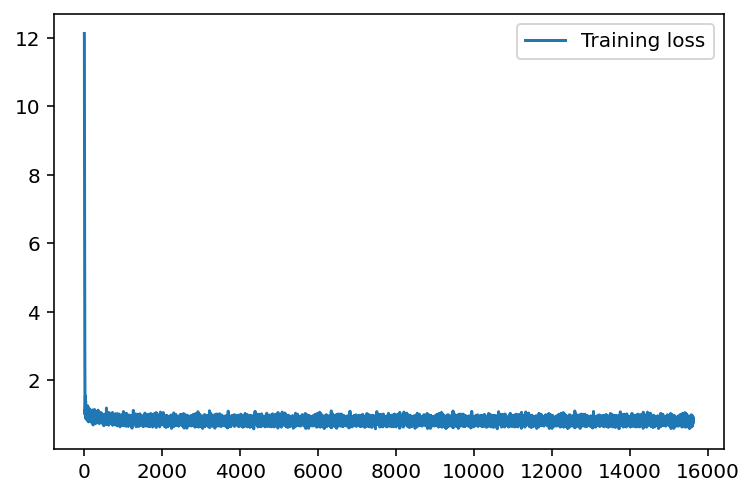

In [218]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(mv_net.losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

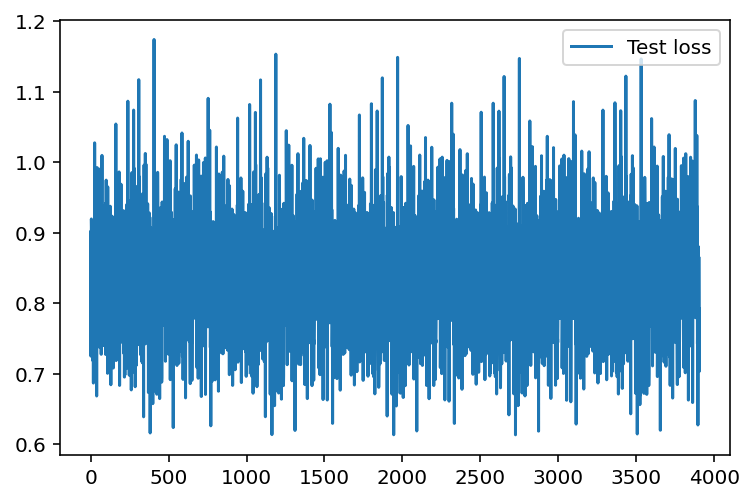

In [219]:
plt.plot(mv_net.losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

## Retrieve Movie Matrix

In [229]:
movie_layer_model = keras.models.Model(inputs=[mv_net.model.input[4], mv_net.model.input[5], mv_net.model.input[6]], 
                                 outputs=mv_net.model.get_layer("movie_combine_layer_flat").output)
movie_matrics = []

for item in movies.values:
    categories = np.zeros([1, 18])
    categories[0] = item.take(2)#make category the category column

    titles = np.zeros([1, sentences_size])#15
    titles[0] = item.take(1) #make titles the title column

    movie_combine_layer_flat_val = movie_layer_model([np.reshape(item.take(0), [1, 1]), categories, titles])  
    movie_matrics.append(movie_combine_layer_flat_val)

pickle.dump((np.array(movie_matrics).reshape(-1, 200)), open('movie_matrics.p', 'wb'))
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

In [256]:
movie_m

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.413171,-0.740928,-0.761173,0.340282,0.519584,0.394121,0.504616,0.344030,-0.362503,0.230844,...,0.101075,-0.399367,0.605287,-0.399712,-0.385481,0.620733,0.562449,0.472518,0.334468,-0.074057
1,0.254314,-0.617922,-0.545221,0.216626,0.524917,0.358933,0.344240,0.210197,-0.169802,0.160941,...,0.216734,-0.508690,0.426749,-0.103587,-0.340634,0.403106,0.382999,0.344006,0.140622,0.027289
2,0.311706,-0.597310,-0.513697,0.333715,0.559538,0.291873,0.468710,0.299082,-0.102944,0.036351,...,-0.016469,-0.574501,0.398907,-0.084339,-0.162019,0.147355,0.267236,0.110931,0.238620,0.084800
3,0.342251,-0.562357,-0.457327,0.324151,0.499788,0.236914,0.465178,0.258288,-0.063155,-0.098706,...,-0.248514,-0.549028,0.414286,-0.064956,-0.043691,0.075441,0.310294,0.044897,0.191537,0.054666
4,0.396932,-0.607217,-0.522229,0.342197,0.518224,0.355363,0.514901,0.296959,-0.111811,-0.023392,...,-0.049114,-0.526771,0.438032,-0.116625,-0.135180,0.116611,0.350283,0.046280,0.273902,0.004715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,0.456738,-0.665197,-0.605978,0.385798,0.530056,0.364006,0.572121,0.389344,-0.194802,0.031290,...,-0.076866,-0.454349,0.508785,-0.301322,-0.179794,0.297160,0.394017,0.128126,0.391464,-0.020898
3879,0.504752,-0.741659,-0.675724,0.350242,0.537327,0.338383,0.668560,0.467431,-0.346914,0.043259,...,-0.356876,-0.373599,0.587707,-0.477893,-0.149906,0.510129,0.510991,0.200980,0.478368,-0.057026
3880,0.445366,-0.687439,-0.580452,0.347337,0.578242,0.335881,0.600160,0.363827,-0.207167,-0.021575,...,-0.220894,-0.507044,0.501824,-0.226412,-0.132520,0.306853,0.429122,0.093642,0.382438,0.012201
3881,0.442623,-0.706868,-0.626206,0.372258,0.573261,0.345678,0.651303,0.412072,-0.225044,0.025550,...,-0.246770,-0.455079,0.548091,-0.289643,-0.134939,0.379922,0.484057,0.144279,0.421227,-0.004635


## Retrieve User Matrix

In [141]:
user_layer_model = keras.models.Model(inputs=[mv_net.model.input[0], mv_net.model.input[1], mv_net.model.input[2], mv_net.model.input[3]], 
                                 outputs=mv_net.model.get_layer("user_combine_layer_flat").output)
users_matrics = []

for item in users.values:

    user_combine_layer_flat_val = user_layer_model([np.reshape(item.take(0), [1, 1]), 
                                                    np.reshape(item.take(1), [1, 1]), 
                                                    np.reshape(item.take(2), [1, 1]), 
                                                    np.reshape(item.take(3), [1, 1])])  
    users_matrics.append(user_combine_layer_flat_val)

pickle.dump((np.array(users_matrics).reshape(-1, 200)), open('users_matrics.p', 'wb'))
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

In [248]:
user_m

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.131751,-0.052223,-0.124342,0.061762,0.013406,0.090228,0.118845,0.050239,-0.140223,0.060824,...,0.126063,-0.148078,0.153157,0.102820,-0.186929,0.015105,0.058690,0.091182,0.107546,0.066532
1,0.076371,-0.082882,-0.074178,-0.006520,0.026763,0.065637,0.124335,0.003243,-0.030244,0.093990,...,0.026246,0.015118,0.110805,0.026821,-0.115420,0.051354,0.178632,0.037304,0.023766,-0.070702
2,0.090756,-0.157557,-0.128130,0.049677,0.061348,0.080831,0.107593,0.063825,-0.092351,0.089190,...,0.131700,-0.057045,0.041522,0.068987,-0.147517,-0.013693,0.048996,0.013849,0.067997,0.049599
3,0.063835,-0.092566,-0.092520,-0.035360,-0.018957,0.042754,0.084070,-0.003709,-0.099402,0.027606,...,-0.096888,-0.025940,0.053018,-0.027177,-0.085369,0.074849,0.168394,0.084867,0.071596,-0.103349
4,0.064289,-0.120510,-0.106266,0.006702,0.035972,0.027747,0.057566,0.089825,-0.069360,0.060408,...,-0.042849,-0.019669,0.041025,-0.078389,-0.062433,0.077294,0.031790,0.032920,0.053388,-0.051181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,0.082331,-0.052061,-0.099388,0.024913,0.006282,0.053526,0.087323,0.084369,-0.152865,0.038027,...,-0.053468,-0.053392,0.102312,-0.009338,-0.076561,0.101495,0.031419,0.056754,0.054774,0.009091
6036,0.069575,-0.082812,-0.060105,-0.057807,-0.012062,0.042468,0.136092,0.002547,-0.122425,0.017803,...,-0.055702,-0.007465,0.089997,0.030636,-0.041584,0.074826,0.153410,0.069806,-0.002224,-0.002706
6037,0.070828,-0.081159,-0.072833,-0.000798,0.023492,0.065129,0.121680,0.014252,-0.117163,0.046062,...,-0.048939,-0.020308,0.125346,0.033849,-0.093716,0.086990,0.179801,0.066079,-0.016574,-0.013648
6038,0.096345,-0.068898,-0.069961,-0.024122,0.002710,0.032795,0.133121,0.003144,-0.145058,-0.005490,...,-0.092892,-0.030144,0.111317,0.054338,-0.056322,0.051087,0.154040,0.061160,0.006320,-0.005961


## Movie Recommendations

### 1. Recommend 10 movies for a certain user with ID *234*

In [267]:
def recommend_your_favorite_movie(user_id_val, top_k = 10):

    probs_embeddings = (users_matrics[user_id_val-1]).reshape([1, 200])

    probs_similarity = tf.matmul(probs_embeddings, tf.transpose(movie_matrics))
    sim = (probs_similarity.numpy())
    
    print("Here are the recommended movies：")
    p = np.squeeze(sim)
    p[np.argsort(p)[:-top_k]] = 0
    p = p / np.sum(p)
    results = set()
    while len(results) != 5:
        c = np.random.choice(3883, 1, p=p)[0]
        results.add(c)
    for val in (results):
        print(val)
        print(movies_orig[val])

    return results

In [268]:
recommend_your_favorite_movie(234, 10)

Here are the recommended movies：
902
[914 'My Fair Lady (1964)' 'Musical|Romance']
2128
[2197 'Firelight (1997)' 'Drama']
52
[53 'Lamerica (1994)' 'Drama']
2836
[2905 'Sanjuro (1962)' 'Action|Adventure']
315
[318 'Shawshank Redemption, The (1994)' 'Drama']


{52, 315, 902, 2128, 2836}

### 2. Find what movies are also liked by users who enjoy Speed(1994)

In [269]:
import random

def recommend_other_favorite_movie(movie_id_val, top_k = 20):

    probs_movie_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
    probs_user_favorite_similarity = tf.matmul(probs_movie_embeddings, tf.transpose(users_matrics))
    favorite_user_id = np.argsort(probs_user_favorite_similarity.numpy())[0][-top_k:]
    
    print("Your movie is ：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        
    print("The users enjoy this movie are：{}".format(users_orig[favorite_user_id-1]))
    probs_users_embeddings = (users_matrics[favorite_user_id-1]).reshape([-1, 200])
    probs_similarity = tf.matmul(probs_users_embeddings, tf.transpose(movie_matrics))
    sim = (probs_similarity.numpy())

    p = np.argmax(sim, 1)
    print("Those who watched this also like：")

    if len(set(p)) < 5:
        results = set(p)
    else:
        results = set()
        while len(results) != 5:
            c = p[random.randrange(top_k)]
            results.add(c)
    for val in (results):
        print(val)
        print(movies_orig[val])
        
    return results

In [270]:
recommend_other_favorite_movie(377, 20)

Your movie is ：[377 'Speed (1994)' 'Action|Romance|Thriller']
The users enjoy this movie are：[[2312 'M' 45 0]
 [1348 'F' 1 10]
 [5625 'M' 25 1]
 [446 'F' 50 0]
 [445 'M' 45 12]
 [1053 'M' 35 0]
 [451 'M' 56 13]
 [660 'M' 45 16]
 [4993 'M' 45 17]
 [3323 'M' 35 14]
 [3591 'M' 35 6]
 [4754 'F' 18 0]
 [566 'M' 25 17]
 [2362 'M' 25 14]
 [120 'M' 25 11]
 [277 'F' 35 1]
 [2338 'M' 45 17]
 [1855 'M' 18 4]
 [4903 'M' 35 12]
 [1985 'M' 45 12]]
Those who watched this also like：
777
[787 'Gate of Heavenly Peace, The (1995)' 'Documentary']
2434
[2503 'Apple, The (Sib) (1998)' 'Drama']
315
[318 'Shawshank Redemption, The (1994)' 'Drama']
3078
[3147 'Green Mile, The (1999)' 'Drama|Thriller']


{315, 777, 2434, 3078}